<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np
import seaborn as sns

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
print(response)
j_res = json.loads(response.text) # json文字列をdictへ
print(j_res.keys())
j_res['patients_summary']['data'][-15:]

<Response [200]>
dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])


[{'小計': 3011, '日付': '2022-05-09T08:00:00.000Z'},
 {'小計': 4451, '日付': '2022-05-10T08:00:00.000Z'},
 {'小計': 4764, '日付': '2022-05-11T08:00:00.000Z'},
 {'小計': 4216, '日付': '2022-05-12T08:00:00.000Z'},
 {'小計': 4109, '日付': '2022-05-13T08:00:00.000Z'},
 {'小計': 3799, '日付': '2022-05-14T08:00:00.000Z'},
 {'小計': 3348, '日付': '2022-05-15T08:00:00.000Z'},
 {'小計': 2377, '日付': '2022-05-16T08:00:00.000Z'},
 {'小計': 3663, '日付': '2022-05-17T08:00:00.000Z'},
 {'小計': 4355, '日付': '2022-05-18T08:00:00.000Z'},
 {'小計': 4172, '日付': '2022-05-19T08:00:00.000Z'},
 {'小計': 3573, '日付': '2022-05-20T08:00:00.000Z'},
 {'小計': 3464, '日付': '2022-05-21T08:00:00.000Z'},
 {'小計': 3317, '日付': '2022-05-22T08:00:00.000Z'},
 {'小計': 2025, '日付': '2022-05-23T08:00:00.000Z'}]

In [4]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [5]:
keys = ['contacts', 'querents', 'patients_summary']

In [6]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2022-05-19 17:00:00+09:00,276,0,4172,2022-05-19 17:00:00+09:00
2022-05-20 17:00:00+09:00,271,0,3573,2022-05-20 17:00:00+09:00
2022-05-21 17:00:00+09:00,337,0,3464,2022-05-21 17:00:00+09:00
2022-05-22 17:00:00+09:00,261,0,3317,2022-05-22 17:00:00+09:00


In [7]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2022-05-19 17:00:00+09:00,276,0,4172,2022-05-19 17:00:00+09:00,302.857143,2120.0,0.0,0.0,3689.000000,25823.0
2022-05-20 17:00:00+09:00,271,0,3573,2022-05-20 17:00:00+09:00,299.428571,2096.0,0.0,0.0,3612.428571,25287.0
2022-05-21 17:00:00+09:00,337,0,3464,2022-05-21 17:00:00+09:00,292.857143,2050.0,0.0,0.0,3564.571429,24952.0
2022-05-22 17:00:00+09:00,261,0,3317,2022-05-22 17:00:00+09:00,291.857143,2043.0,0.0,0.0,3560.142857,24921.0
2022-05-23 17:00:00+09:00,0,0,2025,2022-05-23 17:00:00+09:00,245.857143,1721.0,0.0,0.0,3509.857143,24569.0


In [8]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2022-05-09 17:00:00+09:00,373,0,3011,2022-05-09 17:00:00+09:00,385.857143,2701.0,0.0,0.0,3269.714286,22888.0,'22w19,Mon
2022-05-10 17:00:00+09:00,332,0,4451,2022-05-10 17:00:00+09:00,387.142857,2710.0,0.0,0.0,3426.000000,23982.0,'22w19,Tue
2022-05-11 17:00:00+09:00,311,0,4764,2022-05-11 17:00:00+09:00,379.571429,2657.0,0.0,0.0,3678.142857,25747.0,'22w19,Wed
2022-05-12 17:00:00+09:00,304,0,4216,2022-05-12 17:00:00+09:00,366.142857,2563.0,0.0,0.0,3949.000000,27643.0,'22w19,Thu
2022-05-13 17:00:00+09:00,295,0,4109,2022-05-13 17:00:00+09:00,350.857143,2456.0,0.0,0.0,4153.000000,29071.0,'22w19,Fri
2022-05-14 17:00:00+09:00,383,0,3799,2022-05-14 17:00:00+09:00,339.857143,2379.0,0.0,0.0,4151.571429,29061.0,'22w19,Sat
2022-05-15 17:00:00+09:00,268,0,3348,2022-05-15 17:00:00+09:00,323.714286,2266.0,0.0,0.0,3956.857143,27698.0,'22w19,Sun
2022-05-16 17:00:00+09:00,322,0,2377,2022-05-16 17:00:00+09:00,316.428571,2215.0,0.0,0.0,3866.285714,27064.0,'22w20,Mon
2022-05-17 17:00:00+09:00,264,0,3663,2022-05-17 17:00:00+09:00,306.714286,2147.0,0.0,0.0,3753.714286,26276.0,'22w20,Tue
2022-05-18 17:00:00+09:00,312,0,4355,2022-05-18 17:00:00+09:00,306.857143,2148.0,0.0,0.0,3695.285714,25867.0,'22w20,Wed


In [9]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [10]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2022-05-08 17:00:00+09:00,3182.857143,22280
2022-05-15 17:00:00+09:00,3956.857143,27698
2022-05-22 17:00:00+09:00,3560.142857,24921
2022-05-23 17:00:00+09:00,2025.000000,2025
2022-01-02 17:00:00+09:00,80.000000,160


In [11]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2022-05-09 17:00:00+09:00,373,0,3011,2022-05-09 17:00:00+09:00,385.857143,2701.0,0.0,0.0,3269.714286,22888.0,'22w19,Mon,NaN,NaN
2022-05-10 17:00:00+09:00,332,0,4451,2022-05-10 17:00:00+09:00,387.142857,2710.0,0.0,0.0,3426.000000,23982.0,'22w19,Tue,NaN,NaN
2022-05-11 17:00:00+09:00,311,0,4764,2022-05-11 17:00:00+09:00,379.571429,2657.0,0.0,0.0,3678.142857,25747.0,'22w19,Wed,NaN,NaN
2022-05-12 17:00:00+09:00,304,0,4216,2022-05-12 17:00:00+09:00,366.142857,2563.0,0.0,0.0,3949.000000,27643.0,'22w19,Thu,NaN,NaN
2022-05-13 17:00:00+09:00,295,0,4109,2022-05-13 17:00:00+09:00,350.857143,2456.0,0.0,0.0,4153.000000,29071.0,'22w19,Fri,NaN,NaN
2022-05-14 17:00:00+09:00,383,0,3799,2022-05-14 17:00:00+09:00,339.857143,2379.0,0.0,0.0,4151.571429,29061.0,'22w19,Sat,NaN,NaN
2022-05-15 17:00:00+09:00,268,0,3348,2022-05-15 17:00:00+09:00,323.714286,2266.0,0.0,0.0,3956.857143,27698.0,'22w19,Sun,3956.857143,27698.0
2022-05-16 17:00:00+09:00,322,0,2377,2022-05-16 17:00:00+09:00,316.428571,2215.0,0.0,0.0,3866.285714,27064.0,'22w20,Mon,NaN,NaN
2022-05-17 17:00:00+09:00,264,0,3663,2022-05-17 17:00:00+09:00,306.714286,2147.0,0.0,0.0,3753.714286,26276.0,'22w20,Tue,NaN,NaN
2022-05-18 17:00:00+09:00,312,0,4355,2022-05-18 17:00:00+09:00,306.857143,2148.0,0.0,0.0,3695.285714,25867.0,'22w20,Wed,NaN,NaN


### グラフ出力

In [12]:
sns.set()
sns.set_style('whitegrid')

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
# y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
# y2_1 = df3['patients_7d_mov_sum']
# y2_2 = df3['patients_week_sum']

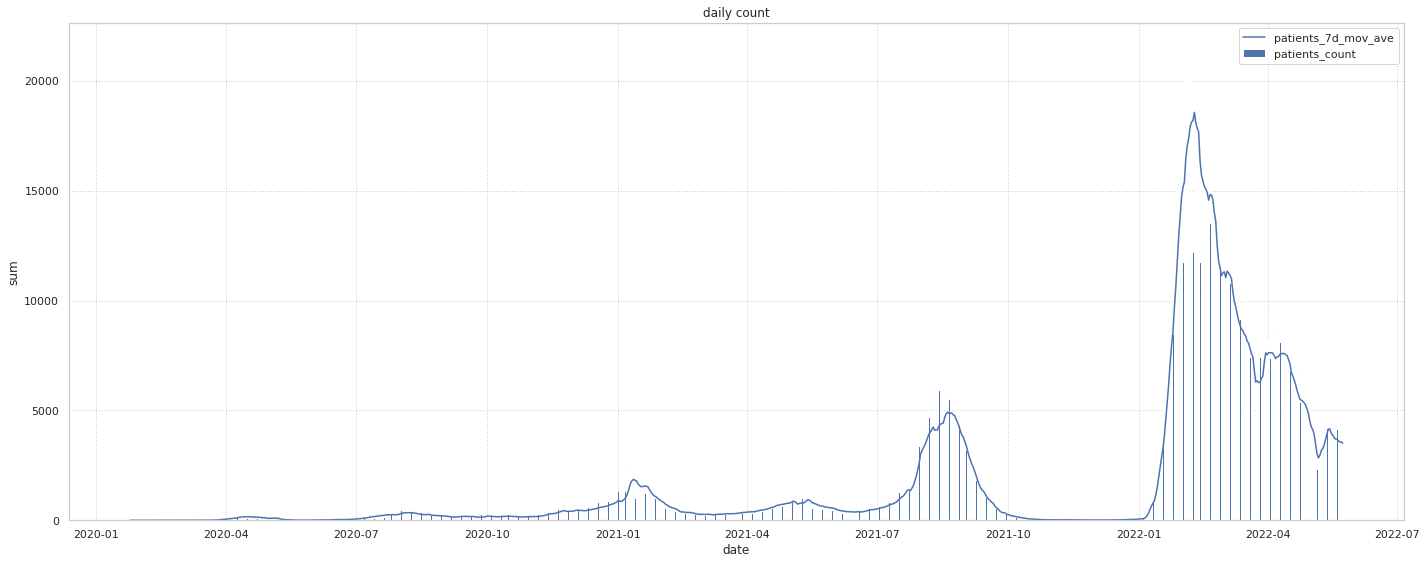

In [15]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

### 日毎の数
ax.set_title('daily count')
ax.set_xlabel('date')
ax.set_ylabel('sum')
ax.bar(x, y1_1, label='patients_count')
ax.plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
# ax[0].bar(x, y1_4, label='patients_week_mean')
ax.grid(linestyle=':')
ax.legend()

# ### 週毎の合計
# ax[1].set_title('weekly count')
# ax[1].set_xlabel('date')
# ax[1].set_ylabel('sum')
# ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
# ax[1].bar(x, y2_2, label='patients_week_sum')
# ax[1].grid(linestyle=':')
# ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,...,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
836,1.652083e+09,2022,5,9,0,1,0,0,0,0,...,762,373,385.857143,2701.0,0,0.0,0.0,3011,3269.714286,22888.0
837,1.652170e+09,2022,5,10,0,0,0,0,0,1,...,763,332,387.142857,2710.0,0,0.0,0.0,4451,3426.000000,23982.0
838,1.652256e+09,2022,5,11,0,0,0,0,0,0,...,764,311,379.571429,2657.0,0,0.0,0.0,4764,3678.142857,25747.0
839,1.652342e+09,2022,5,12,0,0,0,0,1,0,...,765,304,366.142857,2563.0,0,0.0,0.0,4216,3949.000000,27643.0
840,1.652429e+09,2022,5,13,1,0,0,0,0,0,...,766,295,350.857143,2456.0,0,0.0,0.0,4109,4153.000000,29071.0
841,1.652515e+09,2022,5,14,0,0,1,0,0,0,...,767,383,339.857143,2379.0,0,0.0,0.0,3799,4151.571429,29061.0
842,1.652602e+09,2022,5,15,0,0,0,1,0,0,...,768,268,323.714286,2266.0,0,0.0,0.0,3348,3956.857143,27698.0
843,1.652688e+09,2022,5,16,0,1,0,0,0,0,...,769,322,316.428571,2215.0,0,0.0,0.0,2377,3866.285714,27064.0
844,1.652774e+09,2022,5,17,0,0,0,0,0,1,...,770,264,306.714286,2147.0,0,0.0,0.0,3663,3753.714286,26276.0
845,1.652861e+09,2022,5,18,0,0,0,0,0,0,...,771,312,306.857143,2148.0,0,0.0,0.0,4355,3695.285714,25867.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851 entries, 0 to 850
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            851 non-null    float64
 1   year                 851 non-null    int64  
 2   month                851 non-null    int64  
 3   day                  851 non-null    int64  
 4   Fri                  851 non-null    uint8  
 5   Mon                  851 non-null    uint8  
 6   Sat                  851 non-null    uint8  
 7   Sun                  851 non-null    uint8  
 8   Thu                  851 non-null    uint8  
 9   Tue                  851 non-null    uint8  
 10  Wed                  851 non-null    uint8  
 11  passed               851 non-null    int64  
 12  emergency            851 non-null    int64  
 13  em_passed            851 non-null    int64  
 14  contacts_count       851 non-null    int64  
 15  contacts_7d_mov_ave  851 non-null    flo

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,...,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,8.510000e+02,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,...,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000
mean,1.616573e+09,2020.764982,6.061105,15.708578,0.143361,0.143361,0.143361,0.143361,0.142186,0.142186,...,354.260870,672.068155,671.341923,4699.388954,433.042303,433.042303,3031.296122,1784.640423,1773.562246,12414.916569
std,2.123771e+07,0.718656,3.423590,8.794499,0.350646,0.350646,0.350646,0.350646,0.349446,0.349446,...,240.741321,541.929815,529.758467,3708.314953,759.256499,699.536380,4896.754657,3571.640504,3489.603788,24427.236262
min,1.579853e+09,2020.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.598213e+09,2020.000000,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,138.500000,330.500000,334.571429,2342.000000,0.000000,0.000000,0.000000,75.500000,87.000000,609.000000
50%,1.616573e+09,2021.000000,6.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,351.000000,511.000000,517.857143,3625.000000,0.000000,0.000000,0.000000,316.000000,335.714286,2350.000000
75%,1.634933e+09,2021.000000,9.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,563.500000,800.000000,811.000000,5677.000000,783.500000,986.285714,6904.000000,1061.500000,1059.785714,7418.500000
max,1.653293e+09,2022.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,776.000000,3277.000000,2723.000000,19061.000000,4060.000000,2574.142857,18019.000000,21562.000000,18562.285714,129936.000000


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,...,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,0.917358,0.049373,-0.006882,-0.002498,0.002498,-0.000833,0.000833,0.001657,-0.001657,...,0.998937,-0.067826,-0.056273,-0.056271,-0.617478,-0.662628,-0.662628,0.551429,0.565111,0.565112
year,9.173578e-01,1.000000,-0.350868,-0.039143,-0.001531,0.003138,0.003138,0.003138,-0.002637,-0.002637,...,0.922225,0.037707,0.049114,0.049115,-0.607831,-0.659722,-0.659722,0.656480,0.667895,0.667896
month,4.937296e-02,-0.350868,1.000000,-0.001987,-0.002406,-0.002406,-0.010246,-0.006326,0.010430,0.003546,...,0.034554,-0.256684,-0.257205,-0.257203,0.074245,0.099245,0.099245,-0.352040,-0.347983,-0.347981
day,-6.882230e-03,-0.039143,-0.001987,1.000000,0.004408,0.004789,0.004026,0.004408,0.001632,-0.009470,...,-0.006497,0.015529,0.003059,0.003057,0.008085,-0.001567,-0.001567,-0.014511,-0.020105,-0.020106
Fri,-2.497864e-03,-0.001531,-0.002406,0.004408,1.000000,-0.167353,-0.167353,-0.167353,-0.166551,-0.166551,...,-0.002116,-0.017603,-0.001804,-0.001804,0.023292,-0.000890,-0.000890,0.017221,-0.000645,-0.000645
Mon,2.497864e-03,0.003138,-0.002406,0.004789,-0.167353,1.000000,-0.167353,-0.167353,-0.166551,-0.166551,...,0.002525,0.036557,-0.001263,-0.001263,0.094517,-0.000890,-0.000890,-0.069375,0.000564,0.000564
Sat,-8.326213e-04,0.003138,-0.010246,0.004026,-0.167353,-0.167353,1.000000,-0.167353,-0.166551,-0.166551,...,-0.000569,0.046326,-0.001499,-0.001499,-0.110869,-0.000890,-0.000890,0.012102,-0.000169,-0.000169
Sun,8.326213e-04,0.003138,-0.006326,0.004408,-0.167353,-0.167353,-0.167353,1.000000,-0.166551,-0.166551,...,0.000978,-0.025763,-0.001263,-0.001263,-0.102212,-0.000890,-0.000890,-0.010462,0.000286,0.000286
Thu,1.657268e-03,-0.002637,0.010430,0.001632,-0.166551,-0.166551,-0.166551,-0.166551,1.000000,-0.165753,...,0.001279,-0.012600,0.002210,0.002211,0.029008,0.001191,0.001191,0.032908,0.000571,0.000571
Tue,-1.657268e-03,-0.002637,0.003546,-0.009470,-0.166551,-0.166551,-0.166551,-0.166551,-0.165753,1.000000,...,-0.001826,-0.015334,0.001676,0.001677,0.039264,0.001191,0.001191,-0.011399,-0.000604,-0.000604


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
846,1.652947e+09,0,0,0,0,1,0,0,846,0,772,276,0,4172,3689.000000,25823.0
847,1.653034e+09,1,0,0,0,0,0,0,847,0,773,271,0,3573,3612.428571,25287.0
848,1.653120e+09,0,0,1,0,0,0,0,848,0,774,337,0,3464,3564.571429,24952.0
849,1.653206e+09,0,0,0,1,0,0,0,849,0,775,261,0,3317,3560.142857,24921.0


In [26]:
_df2 = _df[['timestamp', 'passed', 'emergency', 'patients_count', 'patients_7d_mov_ave', 'patients_7d_mov_sum']]
_df2

,timestamp,passed,emergency,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,0,0,1,1.000000,1.0
1,1.579939e+09,1,0,1,1.000000,2.0
2,1.580026e+09,2,0,0,0.666667,2.0
3,1.580112e+09,3,0,0,0.500000,2.0
4,1.580198e+09,4,0,0,0.400000,2.0
...,...,...,...,...,...,...
846,1.652947e+09,846,0,4172,3689.000000,25823.0
847,1.653034e+09,847,0,3573,3612.428571,25287.0
848,1.653120e+09,848,0,3464,3564.571429,24952.0
849,1.653206e+09,849,0,3317,3560.142857,24921.0


In [27]:
sns.set(style="ticks", color_codes=True)
#sns.pairplot(data=_df)

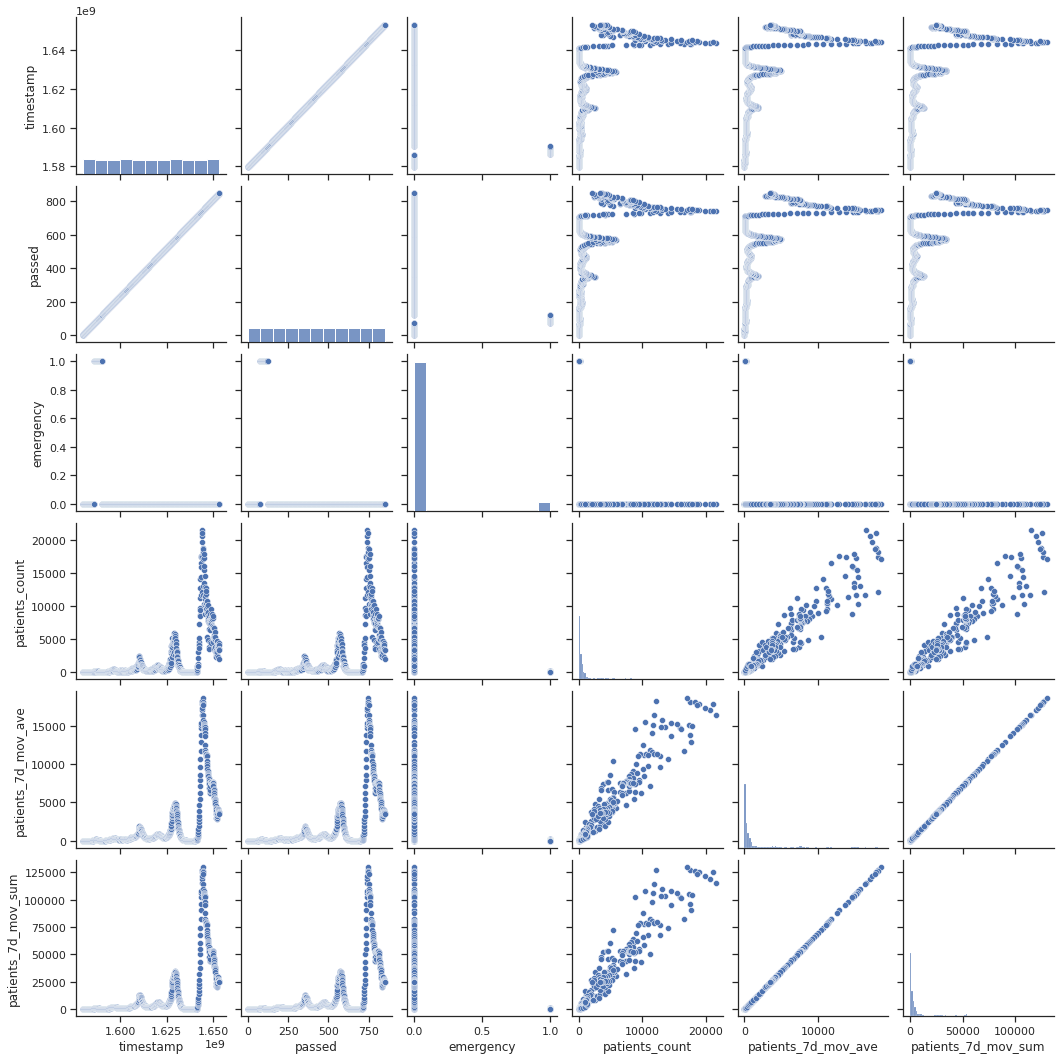

In [28]:
sns.pairplot(data=_df2)

In [29]:
!python -V

Python 3.7.13


In [30]:
!pip freeze

absl-py==1.0.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.2.0
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arviz==0.12.1
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.4.0
audioread==2.1.9
autograd==1.4
Babel==2.10.1
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==5.0.0
blis==0.4.1
bokeh==2.3.3
Bottleneck==1.3.4
branca==0.5.0
bs4==0.0.1
CacheControl==0.12.11
cached-property==1.5.2
cachetools==4.2.4
catalogue==1.0.0
certifi==2021.10.8
cffi==1.15.0
cftime==1.6.0
chardet==3.0.4
charset-normalizer==2.0.12
click==7.1.2
cloudpickle==1.3.0
cmake==3.22.4
cmdstanpy==0.9.5
colorcet==3.0.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.4.0
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.2.7
cvxpy==1.0.31
cycler==0.11.0
cymem==2.0.6
Cython==0.29.30
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dill==0.3.4
distributed=